In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Dense(32, activation = 'relu')(input_A)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent, mod_state):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_curr_state = action_user_one_hot[:]
        mod_curr_state = np.array(mod_curr_state)
        mod_state.append(mod_curr_state)
        new_loc, reward, done = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
prev_timesteps = 4

class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (None,6))    #curr_x, curr_y, target_x, target_y
        x = LSTM(16, return_sequences = True)(input_A)
        x = LSTM(32, return_sequences = True)(x)
        x = LSTM(16)(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 1
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        state_temp = np.array(state)[-4:]
        action_mod = self.exp_policy(state_temp)
        action_user = np.argmax(state[-1][:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        temp_next_state = next_dir_one_hot[:]
        temp_next_state = np.array(temp_next_state)
        next_state = deepcopy(state)
        next_state.append(temp_next_state)
        
        next_state = np.array(next_state)[-4:]
        state = np.array(state)[-4:]
        
        if next_state.shape[0]==4 and state.shape[0]==4:
            self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)

        
        return new_loc, reward_user, done
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.6 0.1]
 [0.1 0.7]
 [0.6 0. ]
 [0.7 0.8]
 [0.4 0.8]
 [0.4 0.6]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
________

  0%|                                                                             | 21/100000 [00:00<15:52, 104.97it/s]

Mean Reward = -2.0
0


  0%|                                                                           | 104/100000 [00:04<2:01:33, 13.70it/s]

Updated Weights
Mean Reward = -0.51
24


  0%|▏                                                                          | 202/100000 [00:10<1:46:03, 15.68it/s]

Updated Weights
Mean Reward = 0.15
26


  0%|▏                                                                          | 304/100000 [00:17<1:48:02, 15.38it/s]

Updated Weights
Mean Reward = 0.27
23


  0%|▎                                                                          | 404/100000 [00:23<1:46:31, 15.58it/s]

Updated Weights
Mean Reward = -1.07
19


  0%|▍                                                                          | 500/100000 [00:30<1:49:34, 15.14it/s]

Updated Weights
Mean Reward = 1.4
28


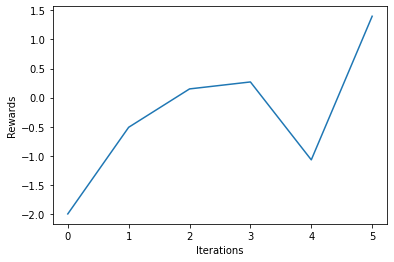

  1%|▍                                                                          | 604/100000 [00:37<1:49:03, 15.19it/s]

Updated Weights
Mean Reward = -1.95
20


  1%|▌                                                                          | 704/100000 [00:44<1:48:37, 15.23it/s]

Updated Weights
Mean Reward = 0.75
26


  1%|▌                                                                          | 802/100000 [00:50<1:48:24, 15.25it/s]

Updated Weights
Mean Reward = -1.61
17


  1%|▋                                                                          | 904/100000 [00:57<1:48:17, 15.25it/s]

Updated Weights
Mean Reward = -0.4
19


  1%|▋                                                                         | 1000/100000 [01:03<1:47:49, 15.30it/s]

Updated Weights
Mean Reward = 0.28
22


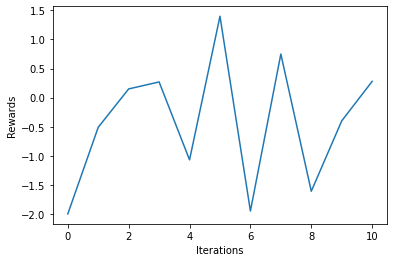

  1%|▊                                                                         | 1104/100000 [01:11<1:48:56, 15.13it/s]

Updated Weights
Mean Reward = -0.58
16


  1%|▉                                                                         | 1202/100000 [01:18<1:45:17, 15.64it/s]

Updated Weights
Mean Reward = -0.77
14


  1%|▉                                                                         | 1302/100000 [01:25<2:12:13, 12.44it/s]

Updated Weights
Mean Reward = -0.53
20


  1%|█                                                                         | 1404/100000 [01:32<1:45:12, 15.62it/s]

Updated Weights
Mean Reward = -1.2
16


  2%|█                                                                         | 1500/100000 [01:39<1:42:41, 15.99it/s]

Updated Weights
Mean Reward = 0.02
25


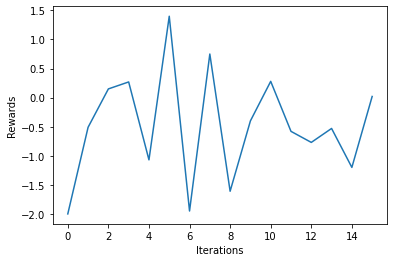

  2%|█▏                                                                        | 1602/100000 [01:45<1:48:41, 15.09it/s]

Updated Weights
Mean Reward = -0.22
23


  2%|█▎                                                                        | 1702/100000 [01:52<1:43:15, 15.87it/s]

Updated Weights
Mean Reward = -1.7
14


  2%|█▎                                                                        | 1804/100000 [01:58<1:39:34, 16.44it/s]

Updated Weights
Mean Reward = -0.92
21


  2%|█▍                                                                        | 1904/100000 [02:04<1:44:16, 15.68it/s]

Updated Weights
Mean Reward = 0.31
25


  2%|█▍                                                                        | 2000/100000 [02:10<1:39:34, 16.40it/s]

Updated Weights
Mean Reward = -0.08
23


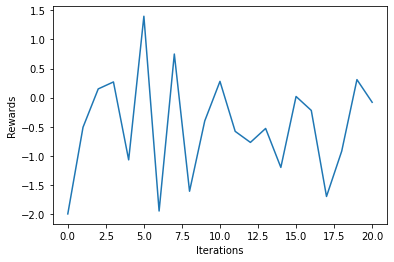

  2%|█▌                                                                        | 2104/100000 [02:17<1:41:10, 16.13it/s]

Updated Weights
Mean Reward = -1.32
20


  2%|█▋                                                                        | 2204/100000 [02:23<1:39:13, 16.43it/s]

Updated Weights
Mean Reward = 0.29
25


  2%|█▋                                                                        | 2302/100000 [02:29<1:42:14, 15.93it/s]

Updated Weights
Mean Reward = -0.93
21


  2%|█▊                                                                        | 2404/100000 [02:36<1:40:45, 16.14it/s]

Updated Weights
Mean Reward = -1.69
19


  2%|█▊                                                                        | 2448/100000 [02:38<1:39:51, 16.28it/s]

In [ ]:
# user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
for epoch in tqdm(range(100000)):
    done = False
    episode_reward = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    mod_state = []    #deque(maxlen = prev_timesteps)
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
        state = next_state
        episode_reward+=reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%2500==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    if epoch%100==0:
        rewards.append(np.mean(mean_rewards))
        mean_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.show()
    

In [ ]:
user_agent.epsilon = 0
done = False
episode_reward = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
mod_state = []
while not done and step<max_steps:
    state = np.array(state)
    print(state)
    next_state, reward, done = user_agent.play_one_step(env, state, mod_agent, mod_state)
    state = next_state
    episode_reward+=reward
    step+=1
    if done:
        reached+=1

In [ ]:
print(done)

In [ ]:
next_states = np.array([mod_agent.replay_buffer.state_history[i] for i in [0,120]])
print(next_states.shape)

In [ ]:
print(next_states)

In [ ]:
np.array(mod_agent.replay_buffer.state_history)